In [3]:
# Import the relevant components
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline



In [4]:

import numpy as np
import sys
import os



In [5]:
import cntk as C
import cntk.tests.test_utils
cntk.tests.test_utils.set_device_from_pytest_env()
C.cntk_py.set_fixed_random_seed(1)

In [6]:

# Ensure we always get the same amount of randomness
np.random.seed(0)

# Define the data dimensions
input_dim = 2
num_output_classes = 2



In [7]:


# Helper function to generate a random data sample
def generate_random_data_sample(sample_size, feature_dim, num_classes):
    # Create synthetic data using NumPy.
    Y = np.random.randint(size=(sample_size, 1), low=0, high=num_classes)

    # Make sure that the data is separable
    X = (np.random.randn(sample_size, feature_dim)+3) * (Y+1)
    X = X.astype(np.float32)
    # converting class 0 into the vector "1 0 0",
    # class 1 into vector "0 1 0", ...
    class_ind = [Y==class_number for class_number in range(num_classes)]
    Y = np.asarray(np.hstack(class_ind), dtype=np.float32)
    return X, Y



In [8]:
# Create the input variables denoting the features and the label data. Note: the input
# does not need additional info on number of observations (Samples) since CNTK first create only
# the network tooplogy first
mysamplesize = 64
features, labels = generate_random_data_sample(mysamplesize, input_dim, num_output_classes)



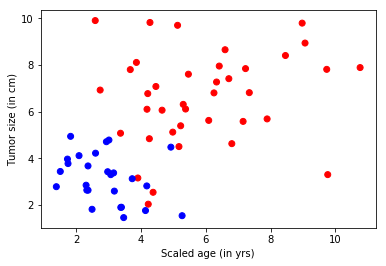

In [9]:
# Plot the data
import matplotlib.pyplot as plt
%matplotlib inline

# given this is a 2 class
colors = ['r' if l == 0 else 'b' for l in labels[:,0]]

plt.scatter(features[:,0], features[:,1], c=colors)
plt.xlabel("Scaled age (in yrs)")
plt.ylabel("Tumor size (in cm)")
plt.show()

In [10]:


num_hidden_layers = 2
hidden_layers_dim = 50



In [11]:
# The input variable (representing 1 observation, in our example of age and size) x, which
# in this case has a dimension of 2.
#
# The label variable has a dimensionality equal to the number of output classes in our case 2.

input = C.input_variable(input_dim)
label = C.input_variable(num_output_classes)

In [12]:
def linear_layer(input_var, output_dim):
    input_dim = input_var.shape[0]

    weight = C.parameter(shape=(input_dim, output_dim))
    bias = C.parameter(shape=(output_dim))

    return bias + C.times(input_var, weight)

In [13]:
def dense_layer(input_var, output_dim, nonlinearity):
    l = linear_layer(input_var, output_dim)

    return nonlinearity(l)

In [15]:


# Define a multilayer feedforward classification model
def fully_connected_classifier_net(input_var, num_output_classes, hidden_layer_dim,
                                   num_hidden_layers, nonlinearity):

    h = dense_layer(input_var, hidden_layer_dim, nonlinearity)
    for i in range(1, num_hidden_layers):
        h = dense_layer(h, hidden_layer_dim, nonlinearity)

    return linear_layer(h, num_output_classes)



In [16]:
# Create the fully connected classfier
z = fully_connected_classifier_net(input, num_output_classes, hidden_layers_dim,
                                   num_hidden_layers, C.sigmoid)


In [17]:
def create_model(features):
    with C.layers.default_options(init=C.layers.glorot_uniform(), activation=C.sigmoid):
        h = features
        for _ in range(num_hidden_layers):
            h = C.layers.Dense(hidden_layers_dim)(h)
        last_layer = C.layers.Dense(num_output_classes, activation = None)

        return last_layer(h)

z = create_model(input)

In [18]:
loss = C.cross_entropy_with_softmax(z, label)

In [19]:
eval_error = C.classification_error(z, label)

In [20]:


# Instantiate the trainer object to drive the model training
learning_rate = 0.5
lr_schedule = C.learning_parameter_schedule(learning_rate)
learner = C.sgd(z.parameters, lr_schedule)
trainer = C.Trainer(z, (loss, eval_error), [learner])



In [21]:
# Define a utility function to compute the moving average sum.
# A more efficient implementation is possible with np.cumsum() function
def moving_average(a, w=10):
    if len(a) < w:
        return a[:]    # Need to send a copy of the array
    return [val if idx < w else sum(a[(idx-w):idx])/w for idx, val in enumerate(a)]


# Defines a utility that prints the training progress
def print_training_progress(trainer, mb, frequency, verbose=1):
    training_loss = "NA"
    eval_error = "NA"

    if mb%frequency == 0:
        training_loss = trainer.previous_minibatch_loss_average
        eval_error = trainer.previous_minibatch_evaluation_average
        if verbose:
            print ("Minibatch: {}, Train Loss: {}, Train Error: {}".format(mb, training_loss, eval_error))

    return mb, training_loss, eval_error

In [22]:
# Initialize the parameters for the trainer
minibatch_size = 25
num_samples = 20000
num_minibatches_to_train = num_samples / minibatch_size

In [23]:
# Run the trainer and perform model training
training_progress_output_freq = 20

plotdata = {"batchsize":[], "loss":[], "error":[]}

for i in range(0, int(num_minibatches_to_train)):
    features, labels = generate_random_data_sample(minibatch_size, input_dim, num_output_classes)

    # Specify the input variables mapping in the model to actual minibatch data for training
    trainer.train_minibatch({input : features, label : labels})
    batchsize, loss, error = print_training_progress(trainer, i,
                                                     training_progress_output_freq, verbose=0)

    if not (loss == "NA" or error =="NA"):
        plotdata["batchsize"].append(batchsize)
        plotdata["loss"].append(loss)
        plotdata["error"].append(error)

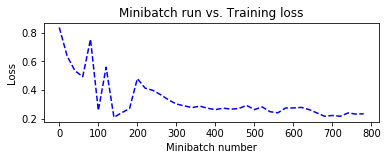

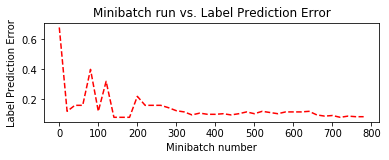

In [24]:

# Compute the moving average loss to smooth out the noise in SGD
plotdata["avgloss"] = moving_average(plotdata["loss"])
plotdata["avgerror"] = moving_average(plotdata["error"])

# Plot the training loss and the training error
import matplotlib.pyplot as plt

plt.figure(1)
plt.subplot(211)
plt.plot(plotdata["batchsize"], plotdata["avgloss"], 'b--')
plt.xlabel('Minibatch number')
plt.ylabel('Loss')
plt.title('Minibatch run vs. Training loss')

plt.show()

plt.subplot(212)
plt.plot(plotdata["batchsize"], plotdata["avgerror"], 'r--')
plt.xlabel('Minibatch number')
plt.ylabel('Label Prediction Error')
plt.title('Minibatch run vs. Label Prediction Error')
plt.show()



In [25]:

# Generate new data
test_minibatch_size = 25
features, labels = generate_random_data_sample(test_minibatch_size, input_dim, num_output_classes)

trainer.test_minibatch({input : features, label : labels})



0.12

In [26]:

# Generate new data
test_minibatch_size = 25
features, labels = generate_random_data_sample(test_minibatch_size, input_dim, num_output_classes)

trainer.test_minibatch({input : features, label : labels})



0.04

In [27]:

# Generate new data
test_minibatch_size = 25
features, labels = generate_random_data_sample(test_minibatch_size, input_dim, num_output_classes)

trainer.test_minibatch({input : features, label : labels})



0.12

In [28]:

# Generate new data
test_minibatch_size = 25
features, labels = generate_random_data_sample(test_minibatch_size, input_dim, num_output_classes)

trainer.test_minibatch({input : features, label : labels})



0.04